In [1]:
import torch
from model import LUNet
from matplotlib import pyplot as plt
import numpy as np

from torch.optim.lr_scheduler import StepLR
from train import training_routine_gaussian, training_routine_uniform, training_routine_uniform_method2
from test import testing_routine
from functions import uniform_circle_log_likelihood, uniform_circle_log_likelihood_method2, gaussian_loss_function
from model import save_model, load_model

from pathlib import Path

from visuals import plot_transformed_grid_and_density, compute_uniform_circle_density, compute_gaussian_density

In [2]:
torch.set_default_dtype(torch.float64)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cuda', index=0)

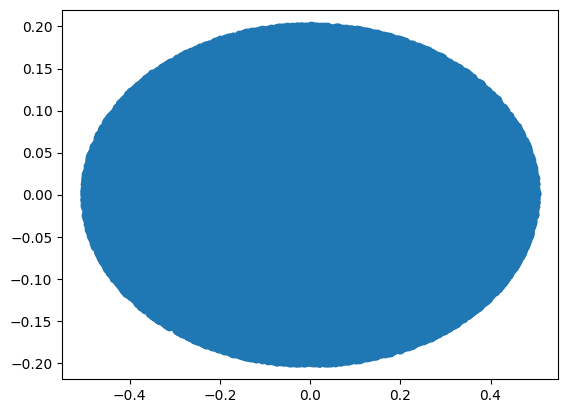

In [3]:
def generate_ellipse(max_num = 10000, scale=(0.5,0.2), device='cpu'):
    data = (torch.rand((max_num,2), device=device)-0.5)*2
    dist = torch.sum(torch.square(data),axis=1)
    data = data[torch.where(dist <= 1)]
    data *= torch.tensor(scale, device=device)
    return data

training_set = generate_ellipse(max_num=100000, scale=(0.5,0.2), device=device)
validation_set = generate_ellipse(max_num=10000, scale=(0.5,0.2), device=device)
plt.scatter(np.array(training_set.cpu())[:,0], np.array(training_set.cpu())[:,1])

In [4]:
# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = torch.utils.data.DataLoader(training_set, batch_size=1024, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=False)

In [9]:
model = LUNet(num_lu_blocks=12, layer_size = 2).to(device)

In [11]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)
num_epochs = 20

In [11]:
%%time

for epoch in range(1, num_epochs + 1):
    training_routine_uniform_method2(model, train_loader, optimizer, loss_function=uniform_circle_log_likelihood_method2)
    testing_routine(model, validation_loader,loss_function=uniform_circle_log_likelihood_method2)
    scheduler.step()

77it [00:02, 28.23it/s]
62it [00:00, 124.75it/s]


Test set: Average loss: -191.1106


77it [00:02, 30.02it/s]
62it [00:00, 119.46it/s]


Test set: Average loss: -188.5182


77it [00:02, 30.26it/s]
62it [00:00, 118.55it/s]


Test set: Average loss: -139.7626


77it [00:02, 30.36it/s]
62it [00:00, 119.46it/s]


Test set: Average loss: -204.6630


77it [00:02, 30.33it/s]
62it [00:00, 120.39it/s]


Test set: Average loss: -224.1890


77it [00:02, 30.21it/s]
62it [00:00, 123.75it/s]


Test set: Average loss: -222.6580


77it [00:02, 29.16it/s]
62it [00:00, 123.75it/s]


Test set: Average loss: -226.1003


77it [00:02, 30.47it/s]
62it [00:00, 118.54it/s]


Test set: Average loss: -110.9841


77it [00:02, 30.53it/s]
62it [00:00, 122.28it/s]


Test set: Average loss: -99.2032


77it [00:02, 30.35it/s]
62it [00:00, 120.62it/s]


Test set: Average loss: -231.8319


77it [00:02, 30.14it/s]
62it [00:00, 118.32it/s]


Test set: Average loss: -232.0964


77it [00:02, 30.22it/s]
62it [00:00, 119.46it/s]


Test set: Average loss: 22.3919


77it [00:02, 30.46it/s]
62it [00:00, 122.28it/s]


Test set: Average loss: -262.5835


77it [00:02, 30.59it/s]
62it [00:00, 123.02it/s]


Test set: Average loss: -240.9365


77it [00:02, 30.00it/s]
62it [00:00, 122.04it/s]


Test set: Average loss: -182.6530


77it [00:02, 29.28it/s]
62it [00:00, 120.15it/s]


Test set: Average loss: -241.6133


77it [00:02, 29.91it/s]
62it [00:00, 120.62it/s]


Test set: Average loss: -225.0057


77it [00:02, 29.91it/s]
62it [00:00, 118.99it/s]


Test set: Average loss: -269.0995


77it [00:02, 29.95it/s]
62it [00:00, 116.76it/s]


Test set: Average loss: -256.9688


77it [00:02, 31.34it/s]
62it [00:00, 137.46it/s]

Test set: Average loss: -261.6557
CPU times: total: 1min 33s
Wall time: 1min 1s


0

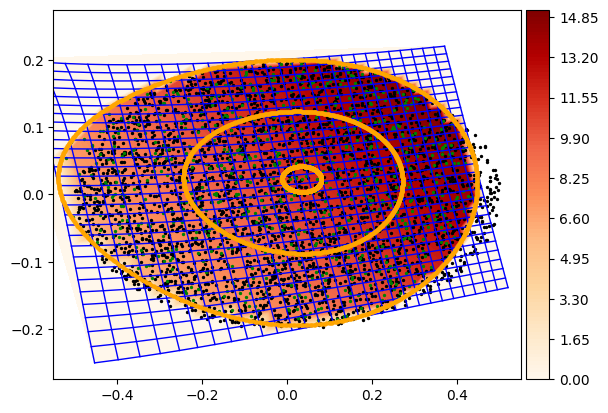

In [8]:
scale=1.1
factor=1

sampling_data = generate_ellipse(1000, (1, 1))
plot_transformed_grid_and_density(model, training_set.to('cpu'), device, sampling_data, grid_width=30, grid_shape=(1000,3),
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-0.5*scale,0.5*scale), y_lim=(-0.25*scale,0.25*scale),
                                density_function=compute_uniform_circle_density, name='LU_ellipse_3.png')

C:\Users\Admin\AppData\Local\Temp\ipykernel_24636\4193416005.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(sampling_data, device=device), reverse=True)


0

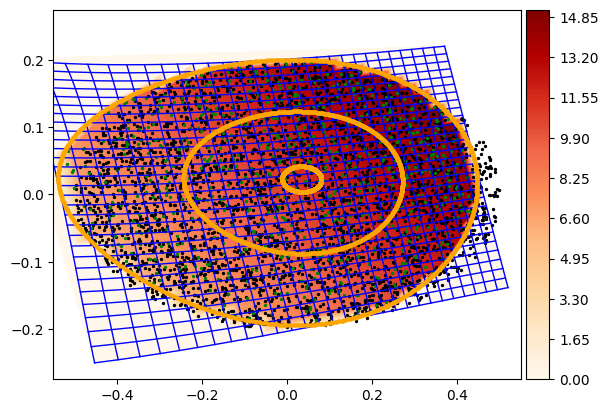

In [13]:
#save_model(model, data='ellipse', checkpoint_number=1)
model_loaded = load_model(num_lu_blocks=12, layer_size=2, path=f"./lu_uniform/ellipse/experiment{1}.pth")

scale=1.1
factor=1

sampling_data = generate_ellipse(1000, (1, 1))
plot_transformed_grid_and_density(model_loaded, training_set.to('cpu'), device, sampling_data, grid_width=30, grid_shape=(1000,3),
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-0.5*scale,0.5*scale), y_lim=(-0.25*scale,0.25*scale),
                                density_function=compute_uniform_circle_density, name='random.png')

## Banana Data!

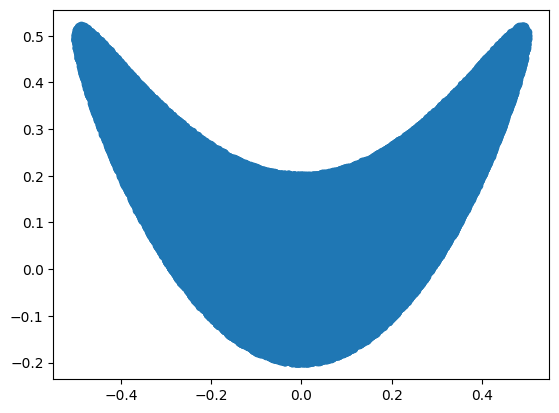

In [249]:
def generate_banana(n=100000, device=device):
    train_loader = generate_ellipse(n, device=device)
    train_loader[:, 1] = train_loader[:,1] + 2*train_loader[:,0]**2
    return train_loader
training_set = generate_banana(n=100000, device=device)
validation_set = generate_banana(n=10000, device=device)
plt.scatter(np.array(training_set.cpu())[:,0], np.array(training_set.cpu())[:,1])

# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = torch.utils.data.DataLoader(training_set, batch_size=1024, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=False)

In [85]:
model_banana = LUNet(num_lu_blocks=12, layer_size = 2).to(device)

In [90]:
optimizer = torch.optim.SGD(model_banana.parameters(), lr=0.08, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)
num_epochs = 20
#init_loss_dict(num_epochs) # number of epochs

In [102]:
scheduler.get_last_lr()

[0.04377253139126089]

In [112]:
%%time

train_with_grid_penalty = False

for epoch in range(1, num_epochs + 1):
    training_routine_uniform_method2(model_banana, train_loader, optimizer, loss_function=uniform_circle_log_likelihood_method2)
    testing_routine(model_banana, validation_loader,loss_function=uniform_circle_log_likelihood_method2)
    scheduler.step()

77it [00:02, 30.82it/s]
62it [00:00, 131.89it/s]


Test set: Average loss: -224.7376


77it [00:02, 32.26it/s]
62it [00:00, 130.79it/s]


Test set: Average loss: -261.6850


77it [00:02, 30.05it/s]
62it [00:00, 127.30it/s]


Test set: Average loss: -261.1219


77it [00:02, 32.04it/s]
62it [00:00, 130.24it/s]


Test set: Average loss: -260.5830


77it [00:02, 31.87it/s]
62it [00:00, 128.90it/s]


Test set: Average loss: -256.8322


77it [00:02, 32.48it/s]
62it [00:00, 126.26it/s]


Test set: Average loss: -260.6171


77it [00:02, 32.59it/s]
62it [00:00, 127.31it/s]


Test set: Average loss: -262.8001


77it [00:02, 32.43it/s]
62it [00:00, 127.83it/s]


Test set: Average loss: -265.5474


77it [00:02, 32.68it/s]
62it [00:00, 111.31it/s]


Test set: Average loss: -255.9381


77it [00:02, 31.92it/s]
62it [00:00, 132.19it/s]


Test set: Average loss: -263.6681


77it [00:02, 31.83it/s]
62it [00:00, 130.52it/s]


Test set: Average loss: -260.6754


77it [00:02, 32.72it/s]
62it [00:00, 132.75it/s]


Test set: Average loss: -264.6775


77it [00:02, 32.71it/s]
62it [00:00, 131.63it/s]


Test set: Average loss: -260.3456


77it [00:02, 32.77it/s]
62it [00:00, 128.36it/s]


Test set: Average loss: -262.8989


77it [00:02, 32.14it/s]
62it [00:00, 125.24it/s]


Test set: Average loss: -261.4911


77it [00:02, 32.35it/s]
62it [00:00, 129.43it/s]


Test set: Average loss: -266.5102


77it [00:02, 31.98it/s]
62it [00:00, 133.61it/s]


Test set: Average loss: -259.8871


77it [00:02, 32.20it/s]
62it [00:00, 133.90it/s]


Test set: Average loss: -262.0979


77it [00:02, 32.42it/s]
62it [00:00, 134.49it/s]


Test set: Average loss: -265.4605


77it [00:02, 32.14it/s]
62it [00:00, 133.33it/s]

Test set: Average loss: -268.7779
CPU times: total: 1min 47s
Wall time: 57.6 s


C:\Users\Admin\AppData\Local\Temp\ipykernel_10804\4193416005.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(sampling_data, device=device), reverse=True)


0

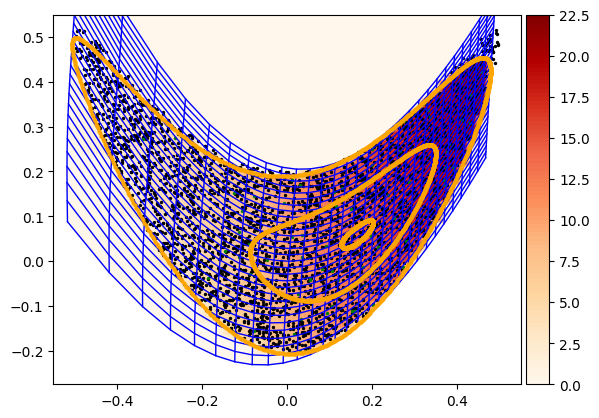

In [113]:
scale=1.1
factor=1.

sampling_data = generate_ellipse(100, (1, 1))
plot_transformed_grid_and_density(model_banana, training_set.to('cpu'), device, sampling_data, grid_width=30, grid_shape=(1000,3),
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-0.5*scale,0.5*scale), y_lim=(-0.25*scale,0.5*scale),
                                density_function=compute_uniform_circle_density, name='LU_banana_3.png')

Saved checkpoint: lu_uniform\banana\experiment1.pth


C:\Users\Admin\AppData\Local\Temp\ipykernel_10804\4193416005.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(sampling_data, device=device), reverse=True)


0

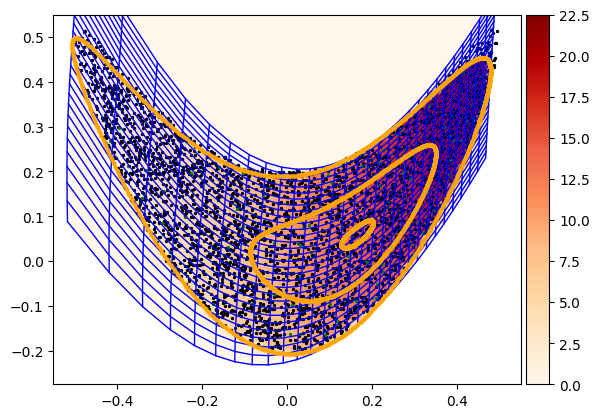

In [250]:
save_model(model_banana, data='banana', checkpoint_number=1)
model_loaded = load_model(num_lu_blocks=12, layer_size=2, path=f"./lu_uniform/banana/experiment{1}.pth")

scale=1.1
factor=1


sampling_data = generate_ellipse(100, (1, 1))
plot_transformed_grid_and_density(model_loaded, training_set.to('cpu'), device, sampling_data, grid_width=30, grid_shape=(1000,3),
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-0.5*scale,0.5*scale), y_lim=(-0.25*scale,0.5*scale),
                                density_function=compute_uniform_circle_density, name='LU_banana_3.png')

## Welle

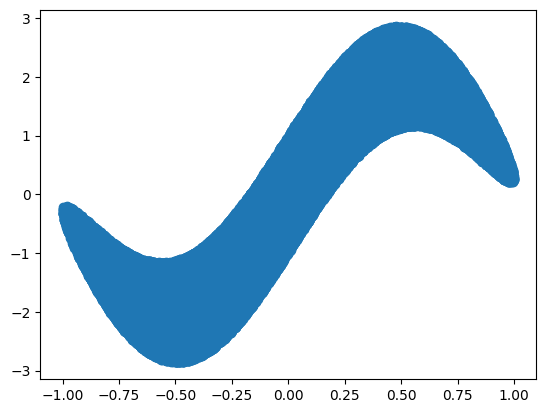

In [252]:
def generate_wave(n=100000, device='cpu'):
    train_loader = generate_ellipse(n, (1,1), device)
    train_loader[:, 1] = train_loader[:,1] + 2*torch.sin(3*train_loader[:,0])
    return train_loader
training_set = generate_wave(n=100000, device=device)
validation_set = generate_wave(n=10000, device=device)
plt.scatter(np.array(training_set.cpu())[:,0], np.array(training_set.cpu())[:,1])

# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = torch.utils.data.DataLoader(training_set, batch_size=1024, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=False)

In [260]:
model_wave = LUNet(num_lu_blocks=10, layer_size = 2).to(device)

In [261]:
optimizer = torch.optim.SGD(model_wave.parameters(), lr=0.1, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.98)
num_epochs = 20

In [130]:
scheduler.get_last_lr()

[0.001]

In [277]:
%%time

train_with_grid_penalty = False

for epoch in range(1, num_epochs + 1):
    training_routine_uniform_method2(model_wave, train_loader, optimizer, loss_function=uniform_circle_log_likelihood_method2)
    testing_routine(model_wave, validation_loader,loss_function=uniform_circle_log_likelihood_method2)
    scheduler.step()

77it [00:02, 37.32it/s]
61it [00:00, 149.13it/s]


Test set: Average loss: 71.2952


77it [00:02, 37.47it/s]
61it [00:00, 153.27it/s]


Test set: Average loss: 69.4868


77it [00:02, 36.17it/s]
61it [00:00, 153.25it/s]


Test set: Average loss: 71.7336


77it [00:02, 36.98it/s]
61it [00:00, 153.27it/s]


Test set: Average loss: 68.7618


77it [00:02, 36.18it/s]
61it [00:00, 150.98it/s]


Test set: Average loss: 76.0796


77it [00:02, 36.68it/s]
61it [00:00, 150.62it/s]


Test set: Average loss: 74.5565


77it [00:02, 36.13it/s]
61it [00:00, 152.48it/s]


Test set: Average loss: 112.9233


77it [00:02, 35.57it/s]
61it [00:00, 150.24it/s]


Test set: Average loss: 68.5760


77it [00:02, 33.82it/s]
61it [00:00, 142.52it/s]


Test set: Average loss: 68.1099


77it [00:02, 36.00it/s]
61it [00:00, 150.62it/s]


Test set: Average loss: 69.0590


77it [00:02, 37.09it/s]
61it [00:00, 149.87it/s]


Test set: Average loss: 66.6812


77it [00:02, 36.93it/s]
61it [00:00, 152.88it/s]


Test set: Average loss: 68.3086


77it [00:02, 37.12it/s]
61it [00:00, 152.50it/s]


Test set: Average loss: 69.3671


77it [00:02, 37.33it/s]
61it [00:00, 151.74it/s]


Test set: Average loss: 67.5518


77it [00:02, 37.32it/s]
61it [00:00, 152.87it/s]


Test set: Average loss: 66.2597


77it [00:02, 37.27it/s]
61it [00:00, 149.95it/s]


Test set: Average loss: 69.7996


77it [00:02, 37.80it/s]
61it [00:00, 151.35it/s]


Test set: Average loss: 65.8968


77it [00:02, 36.85it/s]
61it [00:00, 153.24it/s]


Test set: Average loss: 69.2752


77it [00:02, 36.60it/s]
61it [00:00, 150.23it/s]


Test set: Average loss: 68.3658


77it [00:02, 37.35it/s]
61it [00:00, 153.27it/s]

Test set: Average loss: 72.8673
CPU times: total: 1min 37s
Wall time: 50.1 s


C:\Users\Admin\AppData\Local\Temp\ipykernel_10804\4193416005.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(sampling_data, device=device), reverse=True)


0

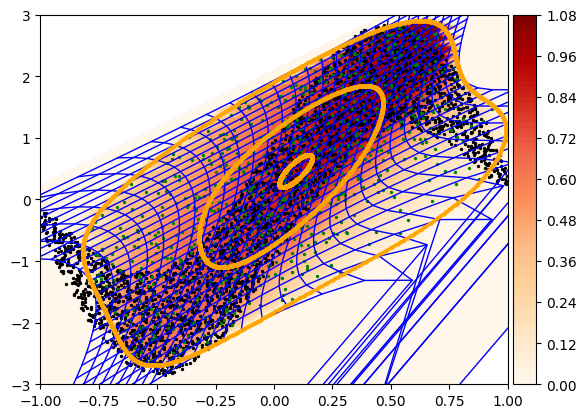

In [278]:
scale=1
factor=1.

sampling_data = generate_ellipse(1000, (1, 1))
plot_transformed_grid_and_density(model_wave, training_set.to('cpu'), device, sampling_data, grid_width=30, grid_shape=(1000,3),
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-1*scale,1*scale), y_lim=(-3*scale,3*scale),
                                density_function=compute_uniform_circle_density, name='LU_wave_5.png')



C:\Users\Admin\AppData\Local\Temp\ipykernel_10804\4193416005.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(sampling_data, device=device), reverse=True)


0

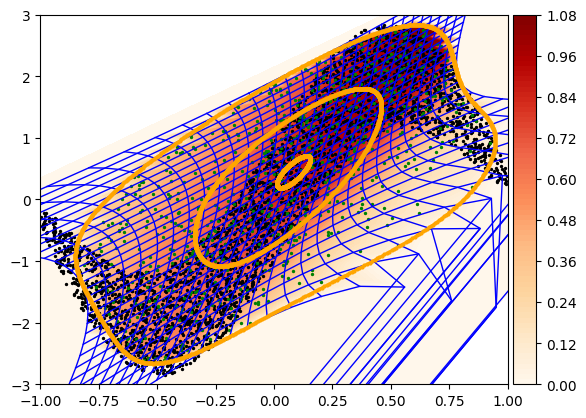

In [279]:
#save_model(model_wave, data='wave', checkpoint_number=1)
model_wave_loaded = load_model(num_lu_blocks=10, layer_size=2, path=f"./lu_uniform/wave/experiment{1}.pth")

scale=1
factor=1.

sampling_data = generate_ellipse(1000, (1, 1))
plot_transformed_grid_and_density(model_wave_loaded, training_set.to('cpu'), device, sampling_data, grid_width=30, grid_shape=(1000,3),
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-1*scale,1*scale), y_lim=(-3*scale,3*scale),
                                density_function=compute_uniform_circle_density, name='random.png')



## Starfish

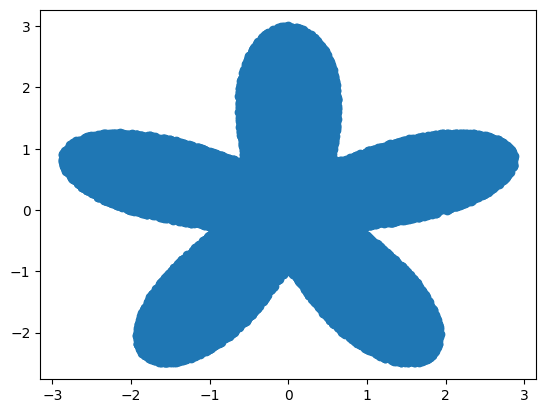

In [245]:
def generate_star(max_num = 10000, n_edges = 5, device='cpu'):
    data = generate_ellipse(max_num, scale=(3,3), device=device)
    angles = torch.arctan2(data[:,1],data[:,0])
    max_amplitude = torch.sin(n_edges*angles)+2
    amplitude = torch.sum(data**2,axis=1)**0.5
    data = data[amplitude <= max_amplitude]
    return data

training_set = generate_star(max_num=100000, n_edges=5, device=device)
validation_set = generate_star(max_num=10000, n_edges=5, device=device)
plt.scatter(np.array(training_set.cpu())[:,0], np.array(training_set.cpu())[:,1])

# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = torch.utils.data.DataLoader(training_set, batch_size=1024, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=False)

In [226]:
model_star = LUNet(num_lu_blocks=10, layer_size = 2).to(device)

In [227]:
optimizer = torch.optim.SGD(model_star.parameters(), lr=0.1, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.95)
num_epochs = 50
#init_loss_dict(num_epochs) # number of epochs

In [202]:
scheduler.get_last_lr()

[0.007694497527671311]

In [231]:
%%time

train_with_grid_penalty = False

for epoch in range(1, num_epochs + 1):
    training_routine_uniform_method2(model_star, train_loader, optimizer, loss_function=uniform_circle_log_likelihood_method2)
    testing_routine(model_star, validation_loader,loss_function=uniform_circle_log_likelihood_method2)
    scheduler.step()

39it [00:01, 29.79it/s]
31it [00:00, 152.69it/s]


Test set: Average loss: 265.3396


39it [00:01, 37.86it/s]
31it [00:00, 150.47it/s]


Test set: Average loss: 270.8678


39it [00:01, 36.86it/s]
31it [00:00, 151.96it/s]


Test set: Average loss: 269.2968


39it [00:01, 36.69it/s]
31it [00:00, 146.22it/s]


Test set: Average loss: 264.6704


39it [00:01, 35.19it/s]
31it [00:00, 149.76it/s]


Test set: Average loss: 264.4488


39it [00:01, 37.97it/s]
31it [00:00, 151.96it/s]


Test set: Average loss: 264.3348


39it [00:01, 36.93it/s]
31it [00:00, 147.62it/s]


Test set: Average loss: 263.2110


39it [00:01, 36.72it/s]
31it [00:00, 151.96it/s]


Test set: Average loss: 262.3465


39it [00:01, 36.86it/s]
31it [00:00, 154.21it/s]


Test set: Average loss: 264.4837


39it [00:01, 37.50it/s]
31it [00:00, 151.21it/s]


Test set: Average loss: 262.3213


39it [00:01, 36.62it/s]
31it [00:00, 153.47it/s]


Test set: Average loss: 262.0458


39it [00:01, 37.00it/s]
31it [00:00, 151.22it/s]


Test set: Average loss: 263.9768


39it [00:01, 36.83it/s]
31it [00:00, 151.22it/s]


Test set: Average loss: 262.2598


39it [00:01, 35.81it/s]
31it [00:00, 152.69it/s]


Test set: Average loss: 262.2787


39it [00:01, 36.83it/s]
31it [00:00, 151.96it/s]


Test set: Average loss: 261.6473


39it [00:01, 37.21it/s]
31it [00:00, 154.61it/s]


Test set: Average loss: 264.6266


39it [00:01, 35.84it/s]
31it [00:00, 151.22it/s]


Test set: Average loss: 261.5608


39it [00:01, 37.85it/s]
31it [00:00, 155.78it/s]


Test set: Average loss: 264.6934


39it [00:01, 37.86it/s]
31it [00:00, 155.78it/s]


Test set: Average loss: 262.5638


39it [00:01, 38.19it/s]
31it [00:00, 153.45it/s]


Test set: Average loss: 261.4296


39it [00:01, 30.83it/s]
31it [00:00, 151.20it/s]


Test set: Average loss: 261.9000


39it [00:01, 36.95it/s]
31it [00:00, 153.46it/s]


Test set: Average loss: 261.2323


39it [00:01, 37.57it/s]
31it [00:00, 142.18it/s]


Test set: Average loss: 262.5445


39it [00:01, 37.36it/s]
31it [00:00, 153.44it/s]


Test set: Average loss: 261.2054


39it [00:01, 38.12it/s]
31it [00:00, 154.98it/s]


Test set: Average loss: 262.2223


39it [00:01, 37.25it/s]
31it [00:00, 152.71it/s]


Test set: Average loss: 261.3730


39it [00:01, 36.86it/s]
31it [00:00, 145.54it/s]


Test set: Average loss: 261.3934


39it [00:01, 35.94it/s]
31it [00:00, 151.96it/s]


Test set: Average loss: 261.1020


39it [00:01, 35.71it/s]
31it [00:00, 144.84it/s]


Test set: Average loss: 261.0630


39it [00:01, 36.65it/s]
31it [00:00, 152.69it/s]


Test set: Average loss: 261.0628


39it [00:01, 37.68it/s]
31it [00:00, 150.49it/s]


Test set: Average loss: 261.2986


39it [00:01, 36.58it/s]
31it [00:00, 145.54it/s]


Test set: Average loss: 261.0861


39it [00:01, 36.48it/s]
31it [00:00, 153.47it/s]


Test set: Average loss: 260.7905


39it [00:01, 36.21it/s]
31it [00:00, 146.92it/s]


Test set: Average loss: 260.8105


39it [00:01, 37.25it/s]
31it [00:00, 151.94it/s]


Test set: Average loss: 260.7275


39it [00:01, 37.94it/s]
31it [00:00, 153.46it/s]


Test set: Average loss: 260.6801


39it [00:01, 36.55it/s]
31it [00:00, 140.27it/s]


Test set: Average loss: 261.5724


39it [00:01, 35.58it/s]
31it [00:00, 151.94it/s]


Test set: Average loss: 260.6504


39it [00:01, 37.46it/s]
31it [00:00, 149.76it/s]


Test set: Average loss: 260.6235


39it [00:01, 37.46it/s]
31it [00:00, 144.86it/s]


Test set: Average loss: 260.7534


39it [00:01, 38.05it/s]
31it [00:00, 152.69it/s]


Test set: Average loss: 260.7653


39it [00:01, 36.90it/s]
31it [00:00, 148.33it/s]


Test set: Average loss: 260.9795


39it [00:01, 37.72it/s]
31it [00:00, 154.98it/s]


Test set: Average loss: 260.5566


39it [00:01, 37.57it/s]
31it [00:00, 142.18it/s]


Test set: Average loss: 260.9938


39it [00:01, 37.68it/s]
31it [00:00, 144.19it/s]


Test set: Average loss: 260.9581


39it [00:01, 37.61it/s]
31it [00:00, 149.74it/s]


Test set: Average loss: 260.7381


39it [00:01, 37.61it/s]
31it [00:00, 151.96it/s]


Test set: Average loss: 260.4701


39it [00:01, 38.20it/s]
31it [00:00, 153.47it/s]


Test set: Average loss: 261.0312


39it [00:01, 36.72it/s]
31it [00:00, 151.96it/s]


Test set: Average loss: 260.3534


39it [00:01, 36.55it/s]
31it [00:00, 156.54it/s]

Test set: Average loss: 260.4325
CPU times: total: 3min 5s
Wall time: 1min 3s


C:\Users\Admin\AppData\Local\Temp\ipykernel_10804\4193416005.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(sampling_data, device=device), reverse=True)


0

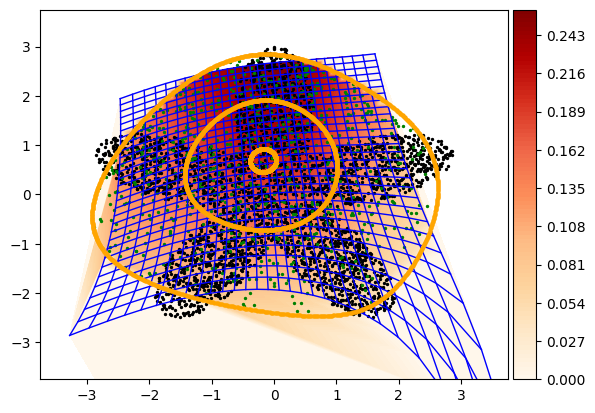

In [230]:
scale=15
factor=0.9

sampling_data = generate_ellipse(1000, (1, 1))
plot_transformed_grid_and_density(model_star, training_set.to('cpu'), device, sampling_data, grid_width=30, grid_shape=(1000,3),
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-0.25*scale,0.25*scale), y_lim=(-0.25*scale,0.25*scale),
                                density_function=compute_uniform_circle_density, name='LU_star.png')

Saved checkpoint: lu_uniform\star\experiment1.pth


C:\Users\Admin\AppData\Local\Temp\ipykernel_10804\4193416005.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(sampling_data, device=device), reverse=True)


0

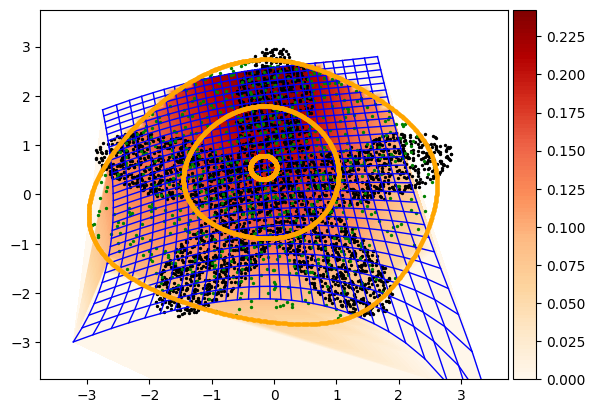

In [247]:
save_model(model_star, data='star', checkpoint_number=1)
model_loaded = load_model(num_lu_blocks=10, layer_size=2, path=f"./lu_uniform/star/experiment{1}.pth")

scale=15
factor=0.9

sampling_data = generate_ellipse(1000, (1, 1))
plot_transformed_grid_and_density(model_loaded, training_set.to('cpu'), device, sampling_data, grid_width=30, grid_shape=(1000,3),
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-0.25*scale,0.25*scale), y_lim=(-0.25*scale,0.25*scale),
                                density_function=compute_uniform_circle_density, name='LU_star_2.png')